### Seasonality Detection

In [304]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [305]:
%watermark -a 'Durga' -v -d -p numpy,pandas,matplotlib,sklearn,seaborn,peakutils,statsmodels

Durga 2016-12-31 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
sklearn 0.18.1
seaborn 0.7.1
peakutils 1.0.3
statsmodels 0.6.1


In [306]:
# CSS File
from IPython.core.display import HTML
from IPython.display import Image

In [307]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

In [308]:
%matplotlib inline

# Libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as npb
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import datetime as dt
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter
from seasonal import fit_seasons, adjust_seasons, fit_trend

import peakutils
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### APIs...

In [309]:
##### DATA API ###########

def read_metric_data(csv_name):
    '''
        Read data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
    print("{0} --- #(rows:columns): {1}".format(csv_name, df.shape))
    return df

def rename_series(series, prefix='v'):
    s = series.unique()
    newS = pd.Series(np.arange(len(s), dtype=np.int))
    newS = newS.apply(lambda x:  prefix + str(x))
    d = dict(zip(s, newS))
    newSeries =series.map(d)
    return newSeries

def expand_df(df, ef=2, freq='D'):
    d = df.copy()
    d1 = pd.concat([df]*ef, ignore_index=True)
    d1.index = pd.date_range(df.index[0], periods=len(d1), freq=freq)
    return d1

In [310]:
##### Seasonality API ###########
def dickey_fuller_test(timeseries):
    #Perform Dickey-Fuller test:
    print 'Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    dfoutput = dfoutput.round(3)
    return dfoutput

def create_line_plot(metric_name, series):
    # Create line chart
    fig = plt.figure(figsize=(12, 3))
    plt.plot(series, color='steelblue')
    plt.ylabel(metric_name)
    plt.gcf().autofmt_xdate()
    return

def create_cycle_plot(acf, indexes):
    plt.figure(figsize=(12,2))
    plt.plot(acf, color='steelblue')
    for i in range(len(indexes)):
        x = indexes[i]
        y = acf[x]
        xy = (x,y)
        xytest = (x+3,1.2*y)
        annotation = label = "cycle. \n(%d)"%(indexes[i]/(i+1))
        plt.annotate(annotation, xy=xy, xytext=xytest, arrowprops=dict(facecolor='slategray'), fontsize=10)
    return

#### Reading & Processing Data...

In [311]:
metric_name = "Disk Utilization (%)"
csv_name = 'data/capacity/du_7d.txt'

# Load data
df1 = read_metric_data(csv_name)
df1.value = df1.value.round(2)

df1 = expand_df(df1, ef=2, freq='D')

data/capacity/du_7d.txt --- #(rows:columns): (168, 2)


#### Summarize data....

Disk utilization(%) summary...


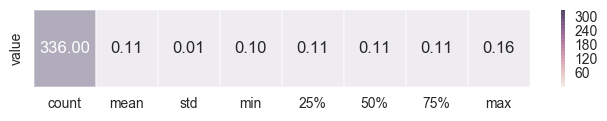

In [312]:
summary = df1.describe()
f, ax = plt.subplots(figsize=(8, 1))
sns.heatmap(summary.T, linewidths=.5, alpha=0.3, annot=True, fmt=".2f")
print("Disk utilization(%) summary...")

#### Seasonality Detection...

In [313]:
print("Checking for stationarity...\n")
df = df1.copy()
dftest = dickey_fuller_test(df.value)
print(dftest)

is_stationary = dftest['Test Statistic'] < dftest['Critical Value (1%)']

if (is_stationary == True):
    df['transform'] = df.value
    
if (is_stationary == False):
    print('\nTrying first diff transformation...')
    df['transform'] = df.value - df.value.shift(1)
    df.diff.dropna(inplace=True)
    dftest = dickey_fuller_test(df.transform)
    print(dftest)
    is_stationary = dftest['Test Statistic'] < dftest['Critical Value (1%)']

if (is_stationary == False):
    print('\nTrying seasonal diff transformation...')
    df['transform'] = df.value - df.value.shift(24)
    df.diff.dropna(inplace=True)
    dftest = dickey_fuller_test(df.transform)
    print(dftest)
    is_stationary = dftest['Test Statistic'] < dftest['Critical Value (1%)']


print("\nStationarity: {%s}"%(is_stationary))

Checking for stationarity...

Dickey-Fuller Test:
Test Statistic          -12.641
p-value                   0.000
#Lags                     2.000
Observations Used       333.000
Critical Value (5%)      -2.870
Critical Value (1%)      -3.450
Critical Value (10%)     -2.571
dtype: float64

Stationarity: {True}


Cycle length: 24


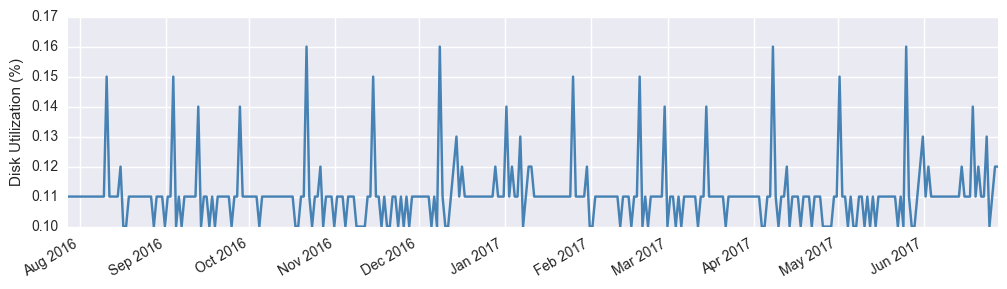

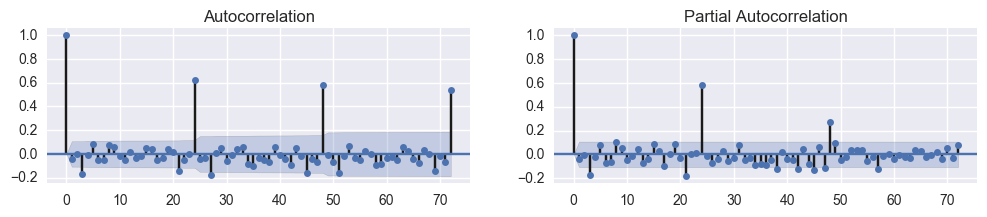

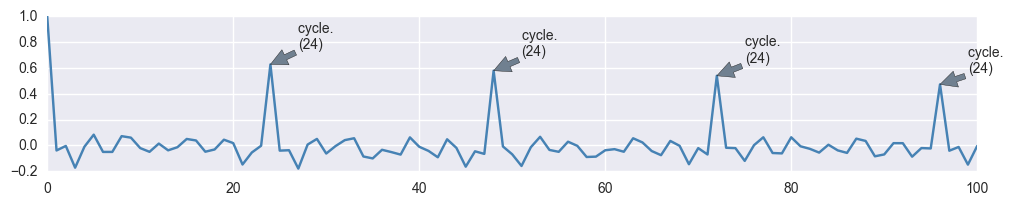

In [314]:
# Graph line plot
create_line_plot(metric_name, df.value)

# Graph ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(12,2))
fig = sm.graphics.tsa.plot_acf(df.ix[1:, 'transform'], lags=72, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df.ix[1:, 'transform'], lags=72, ax=axes[1])

# Graph cycle plot
acf, confint = sm.tsa.stattools.acf(df.ix[1:, 'transform'], nlags=100, fft=True, alpha=0.05)
indexes = peakutils.indexes(acf, thres=0.5)
create_cycle_plot(acf, indexes)

print("Cycle length: %d"%indexes[0])